# Predicting Flight Delays

This project was inspired by [this hortonworks project](http://hortonworks.com/blog/data-science-apacheh-hadoop-predicting-airline-delays/)

This notebook explores a subset of the data, and then goes into the actual predicting with sklearn. Apache Spark, and it's MlLib libarary, will be used to predict with the whole dataset.

In [1]:
import warnings
warnings.filterwarnings('ignore')

import glob
import os
import sys
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from datetime import date
from pprint import pprint
from sklearn import linear_model, cross_validation, metrics, svm
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

%matplotlib inline

Read the monthly CSVs into a DataFrame

In [2]:
#path = '/home/william/Projects/flight-delay/data'
#allFiles = glob.glob(os.path.join(path, '2016*.csv'))
# sort by date
#allFiles.sort(key=lambda path: int(int(path.split('/')[-1][:-4])))
# read in using generator expr for all CSV files
#flights2016 = pd.concat( (pd.read_csv(f, usecols=range(29)) for f in allFiles) )
base = '/home/william/Projects/flight-delay/data/merged'
flights = pd.read_csv(os.path.join(base, '2015.csv'), usecols=range(29))
flights = pd.concat([flights, 
                    pd.read_csv(os.path.join(base, '2016.csv'), usecols=range(29), nrows=1000000)])

Drop excess columns, rename others

In [3]:
renamed_cols = [
        'Year', 'Month', 'Day', 'Dow','CarrierId', 'Carrier', 'TailNum', 'Origin', 
        'Dest', 'CRSDepTime', 'DepTime', 'DepDelay', 'TaxiOut', 'TaxiIn', 'CRSArrTime', 
        'ArrTime', 'ArrDelay', 'Cancelled', 'CancellationCode', 'Diverted', 'CRSElapsedTime', 
        'ActualElapsedTime', 'AirTime', 'Distance', 'CarrierDelay', 'WeatherDelay', 
        'NASDelay', 'SecurityDelay', 'LateAircraftDelay'
]
flights.columns = renamed_cols
to_keep = ['Year', 'Month', 'Day', 'Dow', 'Carrier', 'Origin', 'Dest', 
           'DepDelay', 'CRSDepTime', 'Distance']
    
to_drop = list( set(renamed_cols) - set(to_keep))

flights.drop(to_drop, axis=1, inplace=True)
flights.dropna(subset=['DepDelay'], inplace=True)
# reindex after dropping to keep consecuitive indices
flights.index = range(len(flights))

Graph of delays per month

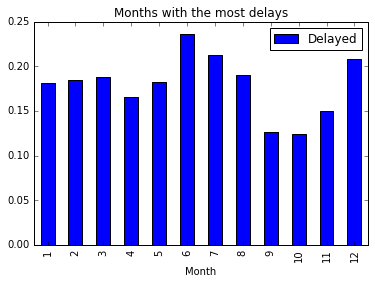

In [4]:
# Compute average number of delayed flights per month
flights['Delayed'] = flights['DepDelay'] >= 15
grouped = flights[['Delayed', 'Month']].groupby('Month').mean()

# plot average delays by month
grouped.plot(kind='bar')
plt.title('Months with the most delays')

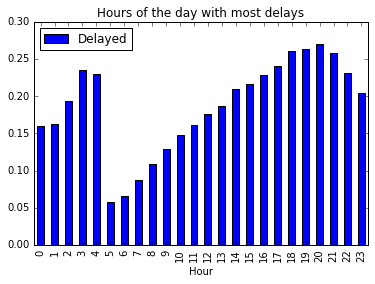

In [5]:
flights['Hour'] = flights['CRSDepTime'].map(lambda x: x // 100)
flights.drop('CRSDepTime', axis=1, inplace=True)
grouped = flights[['Delayed', 'Hour']].groupby('Hour').mean()

# plot average delays by hour of day
grouped.plot(kind='bar')
plt.title('Hours of the day with most delays')

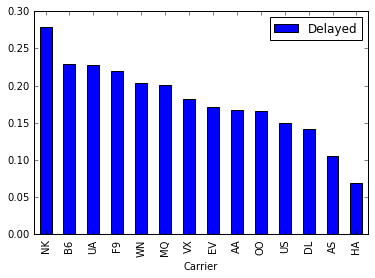

In [6]:
grped1 = flights[ ['Delayed', 'Carrier'] ].groupby('Carrier').filter(lambda x: len(x) > 10)
grped1 = grped1.groupby('Carrier').mean()
grped1 = grped1.sort(['Delayed'], ascending=False)

grped1[:15].plot(kind='bar')

New Year's Day, MLK Day, Easter, Memorial day, July 4th, Labor Day,
Columbus Day, Veterans Day, Thanksgiving, Christmas

In [7]:
%reset_selective -f grped1
%reset_selective -f grped2
%reset_selective -f carrier
%reset_selective -f grouped
%reset_selective -f df

## Building a feature matrix


In [8]:
renamed_cols = ['Year', 'Month', 'Day', 'Dow', 'Carrier', 'Origin', 
                'Dest', 'Delay', 'Distance', 'Delayed', 'Hour']
flights.columns = renamed_cols
# convert the numeric columns from object dtype
numeric_cols = ['Year', 'Month', 'Day', 'Dow', 'Delay', 'Hour', 'Distance']
for col in numeric_cols:
    flights[col] = pd.to_numeric( flights[col] )

Creating Nearest holiday lookup table for 2015 and 2016

New Year's Day, MLK Day, Easter, Memorial day, July 4th, Labor Day, Veteran's Day, Columbus Day, Veteran's Day, Thanksgiving, Christmas 

In [9]:
from datetime import timedelta, date

def daterange(start_date, end_date):
    for n in range(int ((end_date - start_date).days)):
        yield start_date + timedelta(n)
        
holidays_2015 = [
    date(2015, 1, 1), date(2015, 1, 19), date(2015, 4, 5), date(2015, 5, 25),
    date(2015, 7, 4), date(2015, 9, 7), date(2015, 10, 12), date(2015, 11, 11),
    date(2015, 11, 26), date(2015, 12, 25)
]
holidays_2016 = [
    date(2016, 1, 1), date(2016, 1, 18), date(2016, 3, 27), date(2016, 5, 30),
    date(2016, 7, 4),  date(2016, 9, 5), date(2016, 10, 10), date(2016, 11, 11),
    date(2016, 11, 24), date(2016, 12, 25)
]

hday_lookup = {}
for d in daterange( date(2015, 1, 1), date(2017, 1, 1) ):
    holidays = holidays_2015 if d.year == 2015 else holidays_2016
    hday_lookup[d] = min( (abs(d- holiday).days for holiday in holidays) )

Calculating the number of days to the nearest holiday for each row. 

To do this efficiently, first I group by date (since there are thousands of flights for each day), then lookup the date in the lookup table. 

In [10]:
grp_to_indices = flights.groupby(['Year', 'Month','Day']).indices
for d in daterange( date(2015, 1, 1), date(2017, 1, 1)):
    grp_label = (d.year, d.month, d.day)
    if grp_label in grp_to_indices:
        indices = grp_to_indices[grp_label]
        flights.loc[indices, 'HDay'] = hday_lookup[ date(*grp_label) ]

In [11]:
flights[:5]

,Year,Month,Day,Dow,Carrier,Origin,Dest,Delay,Distance,Delayed,Hour,HDay
0,2015,1,22,4,DL,LGA,MCO,-5.0,950.0,False,20,3.0
1,2015,1,22,4,DL,ATL,LGA,26.0,762.0,True,12,3.0
2,2015,1,22,4,DL,SAN,DTW,-6.0,1956.0,False,11,3.0
3,2015,1,22,4,DL,ATL,AGS,-1.0,143.0,False,19,3.0
4,2015,1,22,4,DL,ATL,IAH,-8.0,689.0,False,13,3.0
